In [370]:
import cv2
import torch
import random
import csv
import os
import time
import copy

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import transforms, models, datasets, utils
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [371]:
data_dir = ['./项目三/cv6期项目三-交通标识牌分类项目/traffic-sign/train',
           './项目三/cv6期项目三-交通标识牌分类项目/traffic-sign/test']

train_trfm = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomAffine(20),
    transforms.ColorJitter(0.2,0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])
test_trfm = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder(data_dir[0], train_trfm)
test_set = datasets.ImageFolder(data_dir[1], test_trfm)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

data_size = {'train': len(train_set), 'valid': len(test_set)}
dataloader = {'train': train_loader, 'valid': test_loader}


[40, 45, 47, 53, 19, 39, 55, 14]


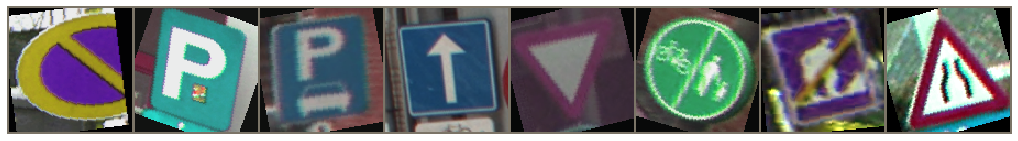

In [372]:
def imshow(image, label):
    
    image = image.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = std * image + mean
    image = np.clip(image, 0, 1)

    fig, ax = plt.subplots(figsize=(18,5))
    print([x.item() for x in label])
    ax.imshow(image)
    ax.axis('off')

    
inputs, classes = next(iter(train_loader))
inputs = inputs[:8]
classes = classes[:8]
out = utils.make_grid(inputs)

imshow(out, classes)


In [404]:
def train(model, dataloader, criterion, optimizer, epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_list = []
    valid_loss_list = []
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_corrects = 0
            model.train() if phase == 'train' else model.eval()
    
            for inputs, classes in dataloader[phase]:
                inputs = inputs.to(device)
                classes = classes.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, pred = torch.max(outputs, 1)
                    loss = criterion(outputs, classes)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == classes.data)
        
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]
            
            if phase == 'train':
                train_loss_list.append(epoch_loss)
            else:
                valid_loss_list.append(epoch_loss)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
    time_elapesd = time.time() - since
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapesd // 60, time_elapesd % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model, train_loss_list, valid_loss_list
        

In [405]:
net_vgg16 = models.vgg16(pretrained=True).to(device)

for param in net_vgg16.features.parameters():
    param.requires_grad = False

num_ftrs = net_vgg16.classifier[6].in_features
net_vgg16.classifier[6] = nn.Linear(num_ftrs, 62)



In [ ]:
epochs = 30
lr = 0.001
model = net_vgg16
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model_vgg16, train_loss_list, valid_loss_list = train(model, dataloader, criterion, optimizer, epochs)
torch.save(model_vgg16, './model_vgg16.pth')

Epoch 1/30
----------
train Loss: 3.1788 Acc: 0.4322
valid Loss: 1.8904 Acc: 0.5317
Epoch 2/30
----------
train Loss: 2.7225 Acc: 0.5238
valid Loss: 1.7454 Acc: 0.5825
Epoch 3/30
----------
train Loss: 2.4618 Acc: 0.5394
valid Loss: 1.7867 Acc: 0.6075
Epoch 4/30
----------
